In [1]:
import numpy as np
import os
import os.path
import matplotlib.pyplot as plt
from collections import OrderedDict
import math

In [2]:
def read_camera_times(frame_id):
    file_path = "./perception_camera_1080/" + str(frame_id) + "_times.txt"
    times_tmp = {}
    with open(file_path) as camera_times_file:
        lines = camera_times_file.readlines()
        for line in lines:
            components = line.strip().split()
            if components[0] != "FeatureExtractor::Extract:":
                times_tmp[components[0]] = float(components[1])
    clusters = [("LanePostprocessing", ["LanePostprocessor::Process2D:", "CalibrationService::Update:", "LanePostprocessor::Process3D:"]),
                ("ObstaclePostprocessor", ["ObstaclePostprocessor::Process:", "Tracker::Associate3D:", "Tracker::Track:", "FillObjectPolygon:"])]
    old_keys_all = []
    for new_key, old_keys in clusters:
        tmp = 0.0
        for old_key in old_keys:
            old_keys_all.append(old_key)
            tmp += times_tmp[old_key]
        times_tmp[new_key] = tmp
    times = OrderedDict()
    times["LaneDetection"] = times_tmp["LaneDetector::Detect:"]
    times["LanePostprocessing"] = times_tmp["LanePostprocessing"]
    times["TrackerPrediction"] = times_tmp["Tracker::Predict:"]
    times["ObstacleDetection"] = times_tmp["YoloObstacleDetector::Detect:"]
    times["TrackerAssociation"] = times_tmp["Tracker::Associate2D:"]
    times["Transformer"] = times_tmp["Transformer::Transform:"]
    times["ObstaclePostprocessing"] = times_tmp["ObstaclePostprocessor"]
    #for key in times_tmp.keys():
     #   if key not in old_keys_all:
     #       times[key] = times_tmp[key]
    return times

In [3]:
def get_frames_count():
    return len([file_name for file_name in os.listdir("./perception_camera_1080/") if file_name.endswith("times.txt")])

In [4]:
def print_frames_stats(frames_times):
    average_response_time = 0.0
    keys = frames_times[0].keys()
    response_times = OrderedDict()
    for key in keys:
        values = np.array([frame_times[key] for frame_times in frames_times])
        mean = np.round(np.mean(values), decimals=2)
        std_dev = np.round(np.std(values), decimals=2)
        response_times[key] = mean
        average_response_time += mean
        print("{} - {} - {}".format(key, mean, std_dev))
    response_times["average_response_time"] = average_response_time
    print("Average response time: {}".format(average_response_time))
    return response_times

In [5]:
def plot_frames_times_vertical_bar_chart(frames_times, response_times, obstacles_detected_counts):
    figure, axes1 = plt.subplots(figsize=(20,10))
    legend_names = []
    legend_bars = []
    inserted_keys = []
    bottoms = np.zeros(len(frames_times))
    zero = 0.0
    for key in response_times.keys():
        if response_times[key] > 1 and key != "average_response_time":
            inserted_keys.append(key)
            values = [frame_times[key] for frame_times in frames_times]
            legend_names.append("{} - {} ms".format(key, response_times[key]))
            legend_bars.append(axes1.bar(np.arange(len(frames_times)), values, width=0.5, bottom=bottoms)[0])
            bottoms += values
    for key in inserted_keys:
        axes1.plot([0, len(frames_times) - 1], [zero + response_times[key], zero + response_times[key]], color="black")
        zero += response_times[key]
    axes1.set_ylabel("Tasks Times [ms]")
    axes1.set_xticks(np.arange(len(frames_times), int(math.sqrt(len(frames_times)))))
    axes1.set_title("Average Response Time {} ms".format(response_times["average_response_time"]))
    axes1.legend(legend_bars, legend_names)
    axes2 = axes1.twinx()
    axes2.plot(range(len(frames_times)), obstacles_detected_counts, "o", color="red")
    axes2.set_ylabel("Obstacles Detected Count")
    plt.savefig("obstacle_detection.svg")

In [6]:
def get_obstacles_detected_count(frame_id):
    file_path = "./perception_camera_1080/" + str(frame_id) + ".txt"
    with open(file_path) as obstacles_detected_file:
        lines = obstacles_detected_file.readlines()
        return int(lines[1])

In [7]:
def plot_gantt_diagram(response_times):
    figure, axes1 = plt.subplots(figsize=(20,10))
    last_time = 0.0
    i = 1
    labels = []
    for key in response_times.keys():
        if key == "average_response_time":
            continue
        time = response_times[key]
        axes1.plot([last_time, time + last_time], [i, i], marker="|", markersize=15, linewidth=2)
        i += 1
        last_time += time
        labels.append(key)
    axes1.set_yticks(range(1, i + 1))
    axes1.set_yticklabels(labels)
    axes1.set_title("Average Response Time {} ms".format(response_times["average_response_time"]))
    plt.savefig("gantt_diagram.svg")

LaneDetection - 38.14 - 0.89
LanePostprocessing - 0.72 - 0.06
TrackerPrediction - 0.01 - 0.0
ObstacleDetection - 9.56 - 0.41
TrackerAssociation - 0.73 - 0.15
Transformer - 0.2 - 0.06
ObstaclePostprocessing - 0.4 - 0.13
Average response time: 49.76


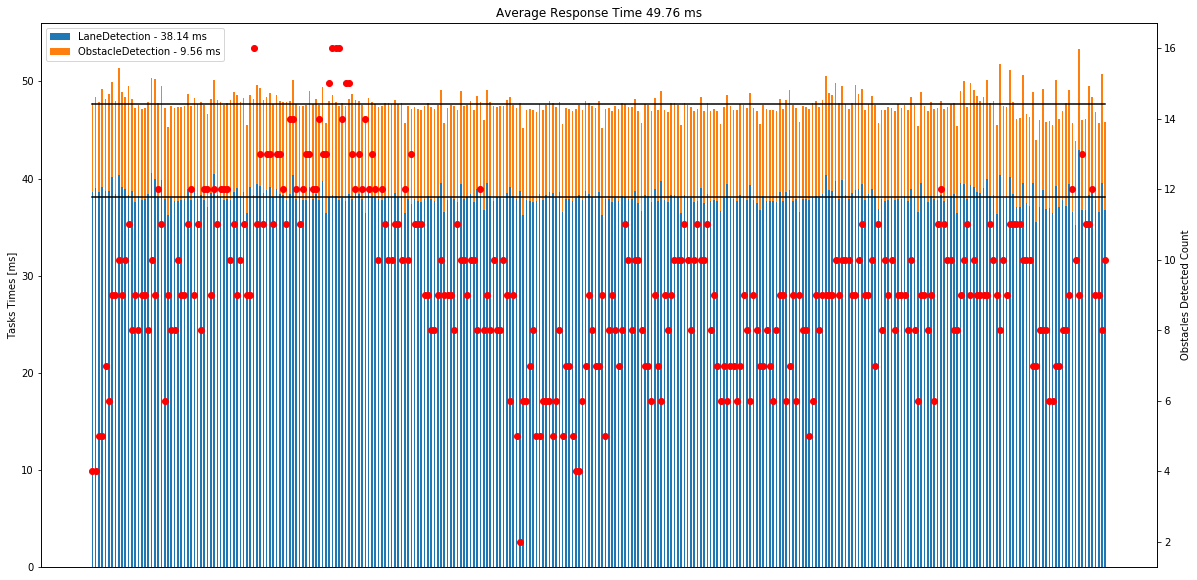

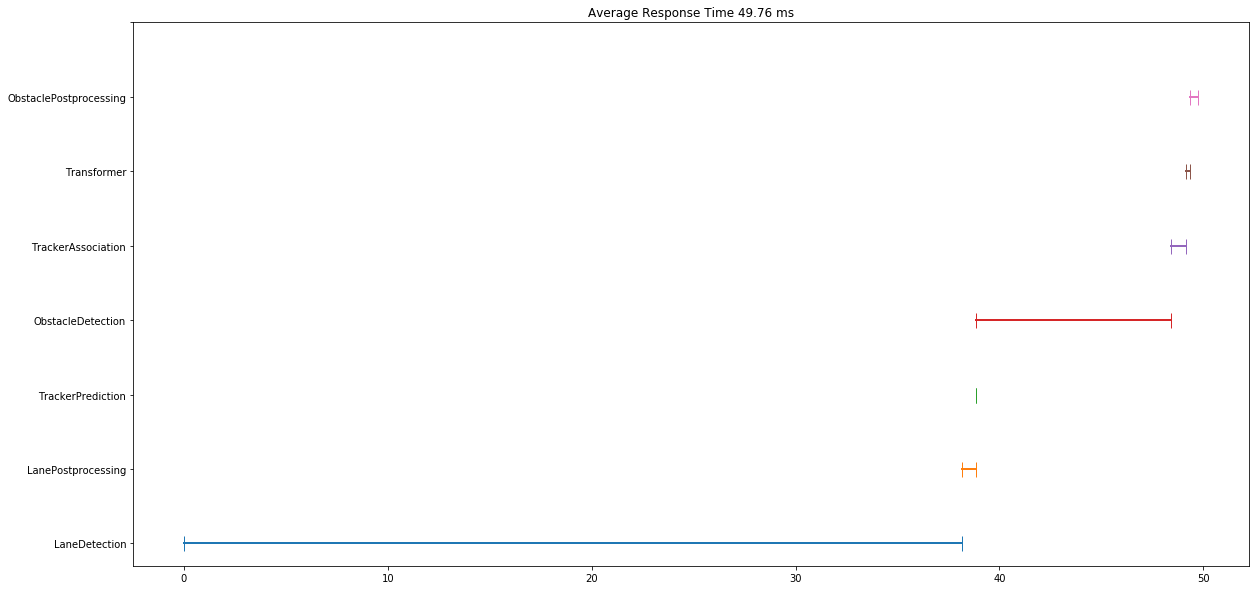

In [8]:
frames_count = get_frames_count() - 1
frames_times = []
obstacles_detected_counts = []
for frame_id in range(2, frames_count + 1):
    frames_times.append(read_camera_times(frame_id))
    obstacles_detected_counts.append(get_obstacles_detected_count(frame_id))
response_times = print_frames_stats(frames_times)
plot_frames_times_vertical_bar_chart(frames_times, response_times, obstacles_detected_counts)
plot_gantt_diagram(response_times)